In [1]:
import os.path
import pickle as pkl
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy.sparse
import torch
import wordcloud
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from keyword_utils import keywords_extractor, keywords_to_adjacency

In [2]:
# Load dataframe
df = pd.read_parquet("twitter_dataset.parquet")

df.drop(columns=["id", "labels", "embeddings"], inplace=True)


# Load or extract keywords
if os.path.exists("keywords.pkl"):
    with open("keywords.pkl", "rb") as file:
        keywords = pkl.load(file)

else:
    texts = df["text"].tolist()

    vectorizer = CountVectorizer(stop_words="english")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    keywords = keywords_extractor(texts, vectorizer, model)

    with open("keywords.pkl", "wb") as file:
        pkl.dump(keywords, file)

keywords = [list(k) for k in keywords]
df.loc[:, "keywords"] = keywords

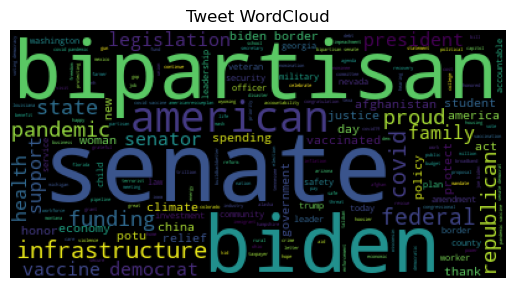

In [3]:
keywords_str = " ".join([x for k_set in keywords for x in k_set])
wc = wordcloud.WordCloud().generate(keywords_str)

plt.figure()
plt.title("Tweet WordCloud")
plt.imshow(wc)
plt.axis("off")
plt.show()

In [4]:
# Load or compute the adjacency matrix
# Degree = number of common keywords
if os.path.exists("adjacency.npy"):
    adjacency = scipy.sparse.load_npz("adjacency_sparse.npz")
else:
    adjacency = keywords_to_adjacency(keywords)
    scipy.sparse.save_npz("adjacency_sparse.npz", adjacency)

Percentage of non-null coefficients: 3.4 %
Number of non-null edges: 216244296


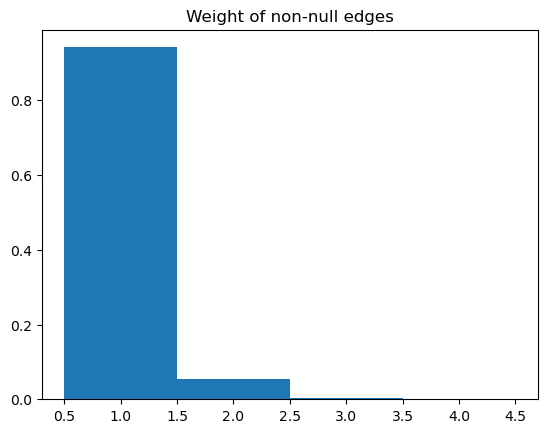

In [5]:
print(f"Percentage of non-null coefficients: {adjacency.data.size / adjacency.shape[0] ** 2 * 100:.1f} %")
print(f"Number of non-null edges: {adjacency.data.size}")

plt.figure()
plt.title("Weight of non-null edges")
plt.hist(adjacency.data, bins=range(1, 6), align="left", density=True)
plt.show()

In [6]:
# Filtering
adjacency = adjacency >= 4

# Create graph and set node attributes
graph = nx.from_scipy_sparse_array(adjacency)

for attribute, values in df.to_dict().items():
    nx.set_node_attributes(graph, values, attribute)

Density: 6.049095118178656e-06


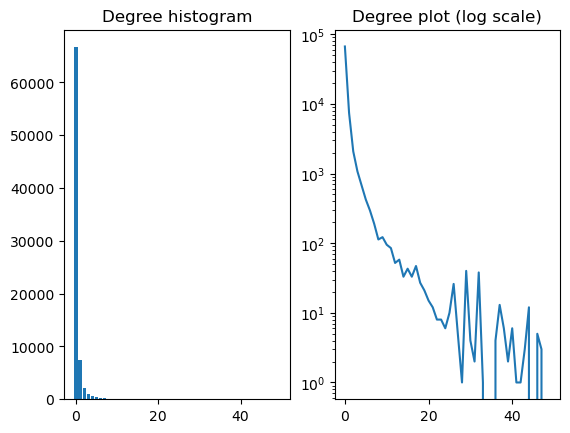

In [7]:
print(f"Density: {nx.density(graph)}")

degree_hist = nx.degree_histogram(graph)

# Cut the histogram 
degree_max = 50

plt.figure()
plt.subplot(121)
plt.title("Degree histogram")
plt.bar(range(degree_max), degree_hist[:degree_max])
plt.subplot(122)
plt.title("Degree plot (log scale)")
plt.semilogy(range(degree_max), degree_hist[:degree_max])
plt.show()

In [8]:
# Keep the largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
graph = nx.subgraph(graph, largest_cc)
graph = nx.convert_node_labels_to_integers(graph)

df = df.iloc[list(largest_cc)]

print(graph)

Graph with 739 nodes and 3308 edges


In [9]:
# Get an embedding of the nodes
laplacian = nx.laplacian_matrix(graph).astype(float)
_, vectors = scipy.sparse.linalg.eigs(laplacian, k=8, which="SM")
vectors = vectors.real

# Compute the TSNE to plot it
vectors_tsne = TSNE().fit_transform(vectors)

df.loc[:, "x"] = vectors_tsne[:, 0]
df.loc[:, "y"] = vectors_tsne[:, 1]

In [10]:
px.scatter(df, x="x", y="y", color="party", hover_data=["username", "keywords"])